In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler

import pyodbc

### Access data from Hive database

In [2]:
conn = pyodbc.connect(DSN = "hive_connection", autocommit = True, ansi = True)

print(conn)

In [3]:
df = pd.read_sql("SELECT * FROM bitcoin", conn, parse_dates=['Date'])

In [4]:
df.head()

,bitcoin.marketdate,bitcoin.open,bitcoin.high,bitcoin.low,bitcoin.close,bitcoin.volume,bitcoin.marketcapacity
0,2020-05-25,8786.11,8951.01,8719.67,8906.93,3.128816e+10,1.637605e+11
1,2020-05-24,9212.28,9288.40,8787.25,8790.37,3.251880e+10,1.616104e+11
2,2020-05-23,9185.06,9302.50,9118.11,9209.29,2.772787e+10,1.693055e+11
3,2020-05-22,9080.33,9232.94,9008.64,9182.58,2.981077e+10,1.688076e+11
4,2020-05-21,9522.74,9555.24,8869.93,9081.76,3.932616e+10,1.669480e+11


In [5]:
df = df[::-1].reset_index(drop=True) # sort date and reindex

In [6]:
df

,bitcoin.marketdate,bitcoin.open,bitcoin.high,bitcoin.low,bitcoin.close,bitcoin.volume,bitcoin.marketcapacity
0,2013-04-28,135.30,135.98,132.10,134.21,0.000000e+00,1.488567e+09
1,2013-04-29,134.44,147.49,134.00,144.54,0.000000e+00,1.603769e+09
2,2013-04-30,144.00,146.93,134.05,139.00,0.000000e+00,1.542813e+09
3,2013-05-01,139.00,139.89,107.72,116.99,0.000000e+00,1.298955e+09
4,2013-05-02,116.38,125.60,92.28,105.21,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
2580,2020-05-21,9522.74,9555.24,8869.93,9081.76,3.932616e+10,1.669480e+11
2581,2020-05-22,9080.33,9232.94,9008.64,9182.58,2.981077e+10,1.688076e+11
2582,2020-05-23,9185.06,9302.50,9118.11,9209.29,2.772787e+10,1.693055e+11
2583,2020-05-24,9212.28,9288.40,8787.25,8790.37,3.251880e+10,1.616104e+11


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2585 entries, 0 to 2584
Data columns (total 7 columns):
bitcoin.marketdate        2585 non-null object
bitcoin.open              2585 non-null float64
bitcoin.high              2585 non-null float64
bitcoin.low               2585 non-null float64
bitcoin.close             2585 non-null float64
bitcoin.volume            2585 non-null float64
bitcoin.marketcapacity    2585 non-null float64
dtypes: float64(6), object(1)
memory usage: 141.5+ KB


In [8]:
df = df.set_index('bitcoin.marketdate') # set market date as index of data
df.index = pd.to_datetime(df.index)

In [9]:
def plot_line_graph(line1, label1=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.set_ylabel('Closing Price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

C:\Users\Tan Chang Jung\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


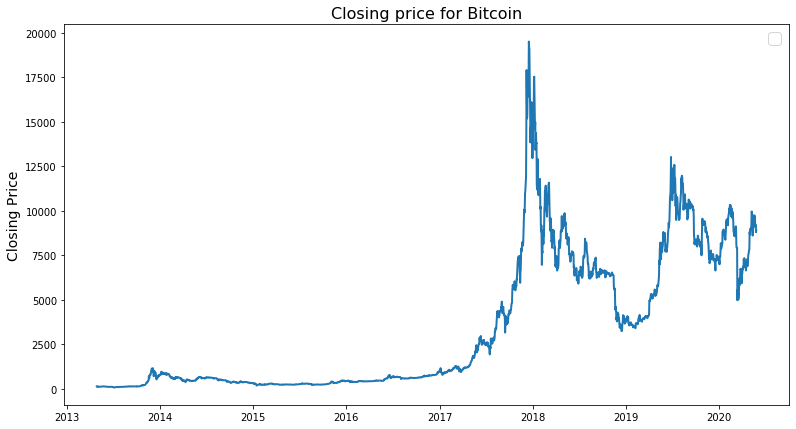

In [10]:
plot_line_graph(df['bitcoin.close'], title='Closing price for Bitcoin')

In [11]:
df_close = df[['bitcoin.close']]

df_close

,bitcoin.close
bitcoin.marketdate,
2013-04-28,134.21
2013-04-29,144.54
2013-04-30,139.00
2013-05-01,116.99
2013-05-02,105.21
...,...
2020-05-21,9081.76
2020-05-22,9182.58
2020-05-23,9209.29


In [12]:
df_close.shape

(2585, 1)

In [13]:
data = df.iloc[:, 0]
history = []
target = []
length = 90

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    history.append(x)
    target.append(y)

A sequence of the values in previous 90 days is used to predict the value at time t.

The last timestep of the first element is same as the 90th timestep of the original data.

The second element of history should be just one timestep shifted version of first element. Therefore, the last timestep in the second element should be equal to the first item of the target variable which is the 91st timestep in the original data.

In [14]:
print(history[1][89]) # to make sure the above script is correct
print(data[90])
print(target[0])

96.02
96.02
96.02


In [15]:
history = np.array(history)  # convert data to numpy array and reshape the target

target = np.array(target)
target = target.reshape(-1,1)

In [16]:
print(history.shape, target.shape)

(2495, 90) (2495, 1)


In [17]:
scaler = MinMaxScaler()
history_scaled = scaler.fit_transform(history)
target_scaled = scaler.fit_transform(target)

Above script used to normalize the data which is squeezing all data points in the range 0 to 1 in a way that the maximum value and minimum values will 1 and 0, respectively. 

In [18]:
history_scaled = history_scaled.reshape((len(history_scaled), length, 1))

print(history_scaled.shape) # reshape the input array to be compatible with LSTM model

(2495, 90, 1)


In [19]:
X_train = history_scaled[:2400,:,:] # 2400 days used for training whereas 95 days used for testing
X_test = history_scaled[2400:,:,:]

y_train = target_scaled[:2400,:]
y_test = target_scaled[2400:,:]

### Build the LSTM model

In [20]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=32, dropout=0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
training_history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
75/75 [==============================] - 3s 40ms/step - loss: 0.0068
Epoch 2/30
75/75 [==============================] - 4s 48ms/step - loss: 0.0023
Epoch 3/30
75/75 [==============================] - 4s 47ms/step - loss: 0.0023
Epoch 4/30
75/75 [==============================] - 4s 47ms/step - loss: 0.0022
Epoch 5/30
75/75 [==============================] - 4s 51ms/step - loss: 0.0021
Epoch 6/30
75/75 [==============================] - 4s 49ms/step - loss: 0.0020
Epoch 7/30
75/75 [==============================] - 4s 48ms/step - loss: 0.0021
Epoch 8/30
75/75 [==============================] - 4s 51ms/step - loss: 0.0020
Epoch 9/30
75/75 [==============================] - 4s 48ms/step - loss: 0.0021
Epoch 10/30
75/75 [==============================] - 4s 52ms/step - loss: 0.0022:
Epoch 11/30
75/75 [==============================] - 4s 58ms/step - loss: 0.0019
Epoch 12/30
75/75 [==============================] - 3s 46ms/step - loss: 0.0018
Epoch 13/30
75/75 [=================

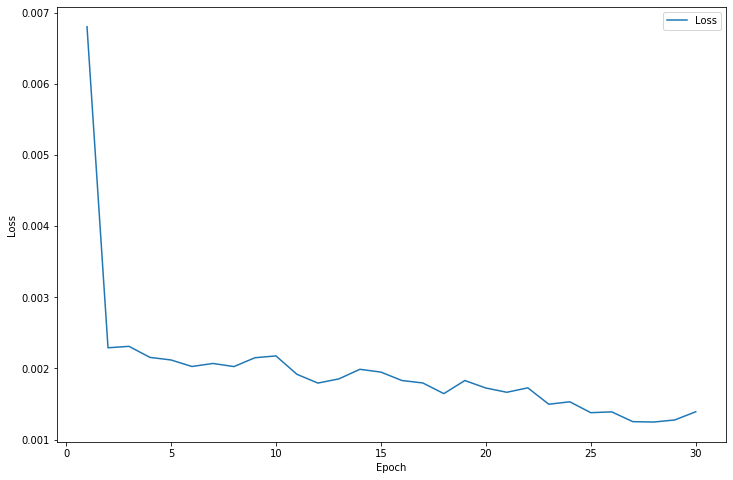

In [23]:
loss = training_history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss)
plt.legend(['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [24]:
prediction = model.predict(X_test)

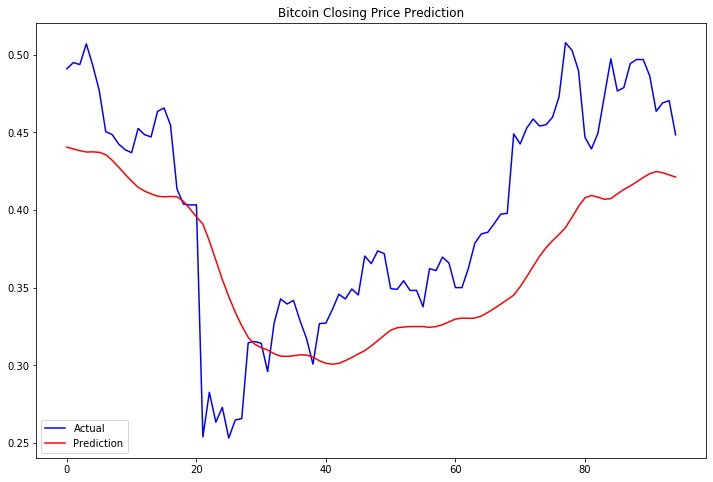

In [25]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(prediction, color='red', label='Prediction')
plt.title('Bitcoin Closing Price Prediction')
plt.legend()
plt.show()

In [27]:
prediction_transformed = scaler.inverse_transform(prediction)
y_test_transformed = scaler.inverse_transform(y_test)

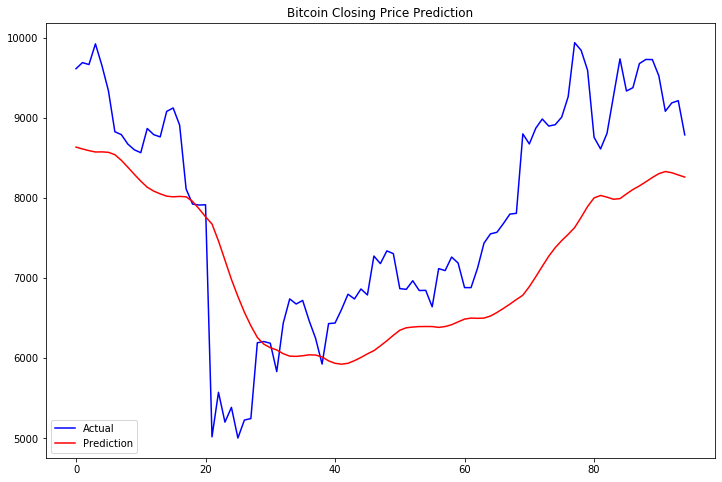

In [28]:
plt.figure(figsize=(12,8))
plt.plot(y_test_transformed, color='blue', label='Actual')
plt.plot(prediction_transformed, color='red', label='Prediction')
plt.title('Bitcoin Closing Price Prediction')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(prediction, y_test))
print(mean_squared_error(prediction_transformed, y_test_transformed))

0.0031855052678051864
1196598.7897701836


There is overfitting in the LSTM model.

The LSTM model does not perform well since the MSE is high when calculating the difference between actual closing price and predicted.